# PATMOS-x: Documentation on extracting IWP

PATMOS-x provides a cloud phase and a cloud water path (CWP) for each observed pixel. One can then use those pixels with ice cloud phase and treat the cloud water path value as the ice water path value. However, this results in a conditional mean, i.e.
$$\mathbb{E}[\text{IWP} \mid (\text{pixel is ice phase}) \cap (\text{daytime conditions})] \quad \text{(wrong)}$$
The condition "$\text{daytime conditions}$" comes from DCOMP, the algorithm used to determine the CWP. DCOMP requires an optical channel, hence the "daytime conditions". The definition of daytime conditions can be ambiguous. This is the main purpose of this notebook, finding how to extract this information from the PATMOS-x data. In addition, the operation between conditions is an intersection $\cap$ since the cloud phase reported in PATMOS-x does not require of daytime conditions.

The goal therefore is to compute
$$\mathbb{E}[\text{IWP} \mid \text{daytime conditions valid for DCOMP}] \quad \text{(correct)}$$
treating IWP as 0 for those pixels with cloud phase not ice.

**Solution to satisfy the above**:
$$\mathbb{E}[\text{IWP} \mid \text{DCOMP optical thickness is finite} \cap \text{cloud phase determined}]$$
where IWP is treated as 0 for those pixels with cloud phase not ice. The '$\cap$ cloud phase determined' is a practicality, and includes 'clear'. This solution comes after noticing that in the [the PATMOS-x v6.0 paper](https://doi.org/10.1175/JCLI-D-22-0147.1) it is mentioned that:
> Clear sky in DCOMP-processed regions reports values of zero for COD while nighttime and DCOMP retrievals that failed to converge are reported as “NaN.” This makes physical sense, since optical thickness of zero is in the defined valid range. In contrast, the REF is not defined if there is no cloud in the observation path and will be reported as “Missing” for all those pixels.

This notebook documents an exploration of the PATMOS-x variables by analysing one PATMOS-x file. For example, which cloud phase mask to use. Comments are at the end of the notebook.

In [1]:
# Imports

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

In [2]:
ds = xr.open_dataset('../patmosx_v06r00_NOAA-19_des_d20191231_c20210814.nc')
# ds = xr.open_dataset('../patmosx_v06r00_NOAA-19_asc_d20191231_c20210814.nc')

LON, LAT = np.meshgrid(ds.longitude.data, ds.latitude.data)

# Extract some info from the dataset
tiwp_conditional = np.where(ds['cloud_phase'] == 4, ds['cld_cwp_dcomp'], np.nan)
phase_is_ice = (ds['cloud_phase'] == 4).data[0]
valid_cwp = np.isfinite(ds.cld_cwp_dcomp.data)[0]
valid_tiwp_conditional = np.isfinite(tiwp_conditional.data)[0]
negative_cpw = (np.isfinite(ds.cld_cwp_dcomp.data) * (ds.cld_cwp_dcomp.data < 0))[0]
valid_cloud_phase = np.isfinite(xr.where(ds['cloud_phase'] == 5, np.nan, ds['cloud_phase'])).data[0]
valid_fraction = np.isfinite(ds.cloud_fraction.data)[0]
valid_probability = np.isfinite(ds.cloud_probability.data)[0]
valid_cwp_clear = (valid_cwp * (ds['cloud_phase'] == 0).data)[0]

valid_cod = np.isfinite(ds.cld_opd_dcomp.data.data)[0]
valid_reff = np.isfinite(ds.cld_reff_dcomp.data)[0]

scan_line_time = xr.where(np.isfinite(ds.scan_line_time.data), ds.scan_line_time.astype(int), np.nan) / 1e9
scan_line_seconds = np.where(scan_line_time.data < 0, np.nan, scan_line_time.data)[0]

scan_line_lst = (scan_line_seconds / 3600 + 12 * LON / 180) * 3600
scan_line_lst = np.where(scan_line_lst < 0, scan_line_lst + 12 * 3600, scan_line_lst)
scan_line_lst = np.where(scan_line_lst > 24 * 3600, scan_line_lst - 24 * 3600, scan_line_lst)

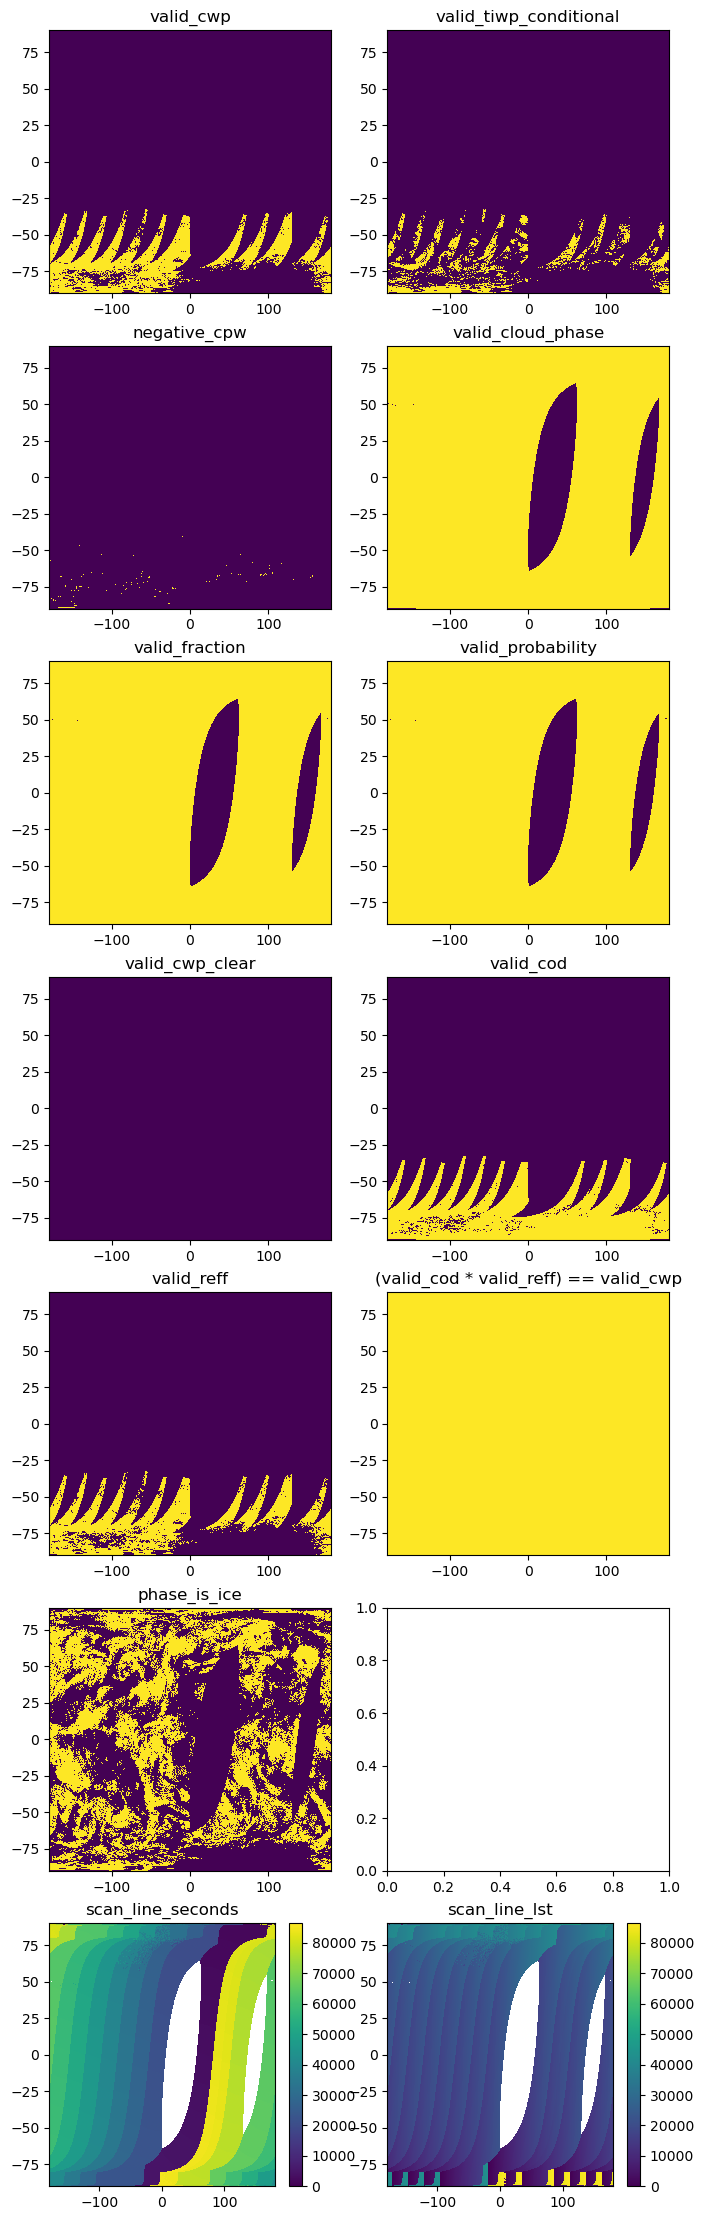

In [3]:
fig, axs = plt.subplots(nrows=7, ncols=2, figsize=(2*4, 7*4))

ax = axs.ravel()[0]
ax.pcolormesh(LON, LAT, valid_cwp, vmin=0, vmax=1)
ax.set_title('valid_cwp')

ax = axs.ravel()[1]
ax.pcolormesh(LON, LAT, valid_tiwp_conditional, vmin=0, vmax=1)
ax.set_title('valid_tiwp_conditional')

ax = axs.ravel()[2]
ax.pcolormesh(LON, LAT, negative_cpw, vmin=0, vmax=1)
ax.set_title('negative_cpw')

ax = axs.ravel()[3]
ax.pcolormesh(LON, LAT, valid_cloud_phase, vmin=0, vmax=1)
ax.set_title('valid_cloud_phase')

ax = axs.ravel()[4]
ax.pcolormesh(LON, LAT, valid_fraction, vmin=0, vmax=1)
ax.set_title('valid_fraction')

ax = axs.ravel()[5]
ax.pcolormesh(LON, LAT, valid_probability, vmin=0, vmax=1)
ax.set_title('valid_probability')

ax = axs.ravel()[6]
ax.pcolormesh(LON, LAT, valid_cwp_clear, vmin=0, vmax=1)
ax.set_title('valid_cwp_clear')

ax = axs.ravel()[7]
ax.pcolormesh(LON, LAT, valid_cod, vmin=0, vmax=1)
ax.set_title('valid_cod')

ax = axs.ravel()[8]
ax.pcolormesh(LON, LAT, valid_reff, vmin=0, vmax=1)
ax.set_title('valid_reff')

ax = axs.ravel()[9]
ax.pcolormesh(LON, LAT, (valid_cod * valid_reff) == valid_cwp, vmin=0, vmax=1)
ax.set_title('(valid_cod * valid_reff) == valid_cwp')

ax = axs.ravel()[10]
ax.pcolormesh(LON, LAT, phase_is_ice, vmin=0, vmax=1)
ax.set_title('phase_is_ice')

ax = axs.ravel()[12]
m = ax.pcolormesh(LON, LAT, scan_line_seconds, vmin=0, vmax=3600*24)
fig.colorbar(m, ax=ax)
ax.set_title('scan_line_seconds')

ax = axs.ravel()[13]
m = ax.pcolormesh(LON, LAT, scan_line_lst, vmin=0, vmax=3600*24)
fig.colorbar(m, ax=ax)
ax.set_title('scan_line_lst')

plt.show()

In [4]:
np.nanmin(ds.cld_cwp_dcomp.data)

-0.00012207031

Can consider negative CWP as 0.

In [5]:
((valid_cod * valid_reff) == valid_cwp).all()

True

Where there is CWP there is both effective radius and cloud optical depth; they likely use a proportionality function ($\text{CWP} \propto r_{\text{eff}} \tau$).

In [6]:
ds.dcomp_info

<xarray.DataArray 'dcomp_info' (time: 1, latitude: 1800, longitude: 3600)> Size: 26MB
[6480000 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 8B 2019-12-31
  * latitude   (latitude) float32 7kB -89.95 -89.85 -89.75 ... 89.75 89.85 89.95
  * longitude  (longitude) float32 14kB -180.0 -179.9 -179.7 ... 179.9 180.0
Attributes:
    long_name:      processing flags for DCOMP 1:land/sea mask (0=land,1=sea)...
    flag_masks:     [  1   2   4   8  16  32  64 128]
    flag_meanings:  land_or_sea_mask day_or_night_mask twilight_@65-82_solar_...

In [7]:
np.unique(ds.dcomp_info.values)

array([-124., -123., -115., -108.,  -92.,  -91.,  -83.,  -76.,    0.,
          2.,    3.,    4.,    5.,   11.,   13.,   18.,   20.,   32.,
         34.,   35.,   36.,   37.,   43.,   45.,   50.,   52.,   68.,
         69.,   77.,   84.,  100.,  101.,  109.,  116.,   nan],
      dtype=float32)

The values seem to represent a number of bits with decimal values, so they should be converted to binary system. But how to treat the negative values in `dcomp_info`? Cast them to `uint8` (as required in the next step), might be a consequence of casting the results to an inappropriate data type from their side. Replace `NaN` with 0.

In [8]:
dcomp_info = xr.where(np.isnan(ds.dcomp_info), 0, ds.dcomp_info).astype(np.uint8)
np.unique(dcomp_info)

array([  0,   2,   3,   4,   5,  11,  13,  18,  20,  32,  34,  35,  36,
        37,  43,  45,  50,  52,  68,  69,  77,  84, 100, 101, 109, 116,
       132, 133, 141, 148, 164, 165, 173, 180], dtype=uint8)

Let's use `numpy.unpackbits` to convert from decimal to bin

In [9]:
dcomp_info_unpacked = np.unpackbits(dcomp_info.data, axis=0, bitorder='little').astype(bool)

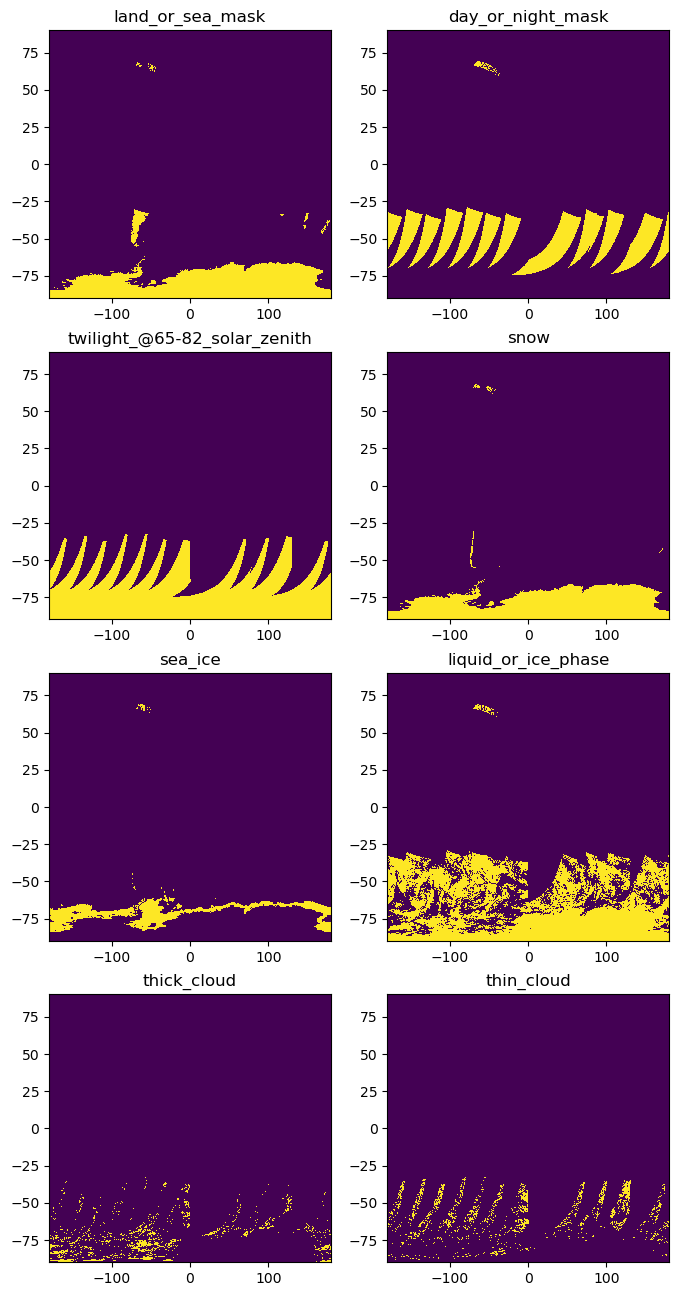

In [10]:
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(2*4, 4*4))

for i in range(8):
    ax = axs.ravel()[i]
    ax.pcolormesh(LON, LAT, dcomp_info_unpacked[i], vmin=0, vmax=1)
    ax.set_title(ds.dcomp_info.flag_meanings.split()[i])

plt.show()

The `land_or_sea_mask` does not make sense. The `day_or_night_mask` seem to be inconsistent with the `valid_cwp` plot. The `liquid_or_ice_phase` does not make sense either. This inconsistencies probably reside in the fact that they require of an additional variable to determine whether the value should be used or not. Also, the `twilight_@65-82_solar_zenith` mask, shouldn't it be reversed?

In [11]:
ds.dcomp_quality

<xarray.DataArray 'dcomp_quality' (time: 1, latitude: 1800, longitude: 3600)> Size: 26MB
[6480000 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 8B 2019-12-31
  * latitude   (latitude) float32 7kB -89.95 -89.85 -89.75 ... 89.75 89.85 89.95
  * longitude  (longitude) float32 14kB -180.0 -179.9 -179.7 ... 179.9 180.0
Attributes:
    standard_name:  quality_flag
    long_name:      quality flags for DCOMP products 1:Processed (0=no,1=yes)...
    flag_masks:     [ 1  2  4  8 16 32 64]
    flag_meanings:  Processed valid_COD_retrieval valid_REF_retrieval degrade...

In [12]:
np.unique(ds.dcomp_quality.data)

array([ 0., 25., 62., 63., nan], dtype=float32)

I will treat `NaN` from `dcomp_quality` as `0`

In [13]:
dcomp_quality = xr.where(ds.dcomp_quality >= 0, ds.dcomp_quality, 0).astype(np.uint8)
np.unique(dcomp_quality)

array([ 0, 25, 62, 63], dtype=uint8)

In [14]:
dcomp_quality_unpacked = np.unpackbits(dcomp_quality.data, axis=0, bitorder='little').astype(bool)

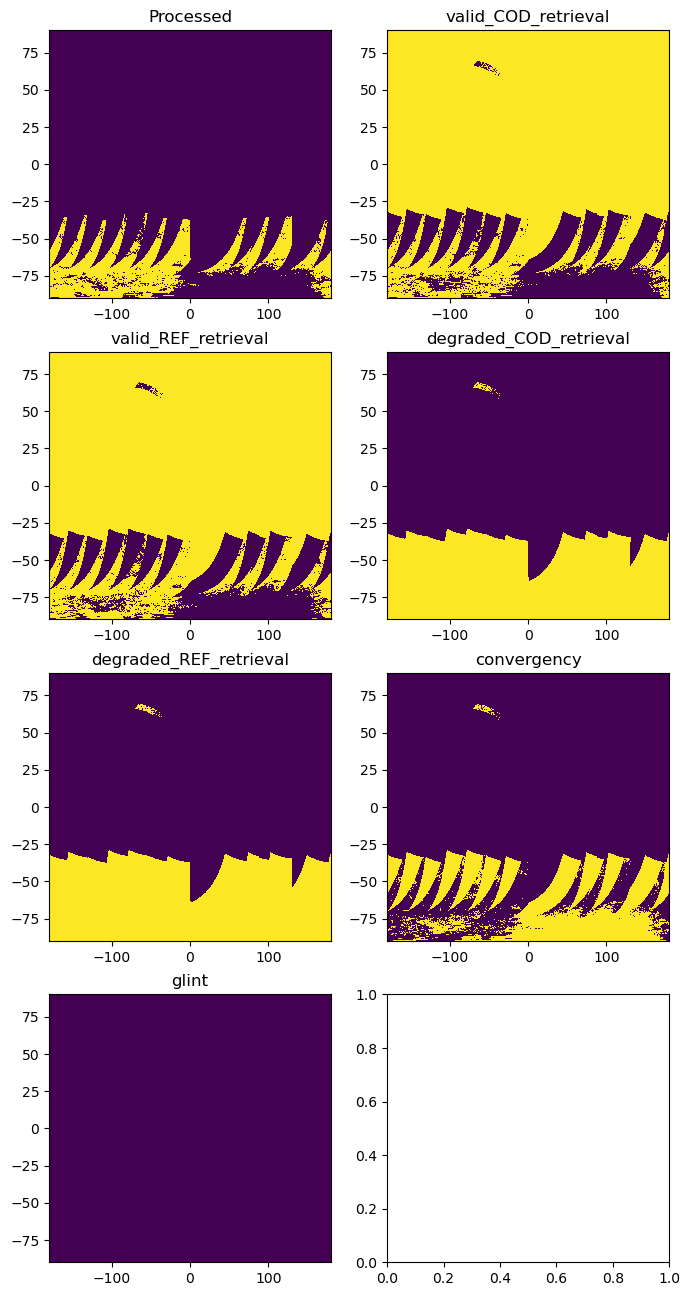

In [15]:
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(2*4, 4*4))

for i in range(7):
    ax = axs.ravel()[i]
    a = dcomp_quality_unpacked[i]
    if i in [1, 2]:
        a = np.invert(a)
    ax.pcolormesh(LON, LAT, a, vmin=0, vmax=1)
    ax.set_title(ds.dcomp_quality.flag_meanings.split()[i])

plt.show()

I cannot make sense of the subplots. `Processed` is not consistent with the `valid_cod` mask. Perhaps it implies that both `valid_cod` and `valid_reff` are not-NaN?

In [16]:
((valid_cod * valid_reff) == dcomp_quality_unpacked[0]).all()

False

The files also have an information on the solar zenith angle:

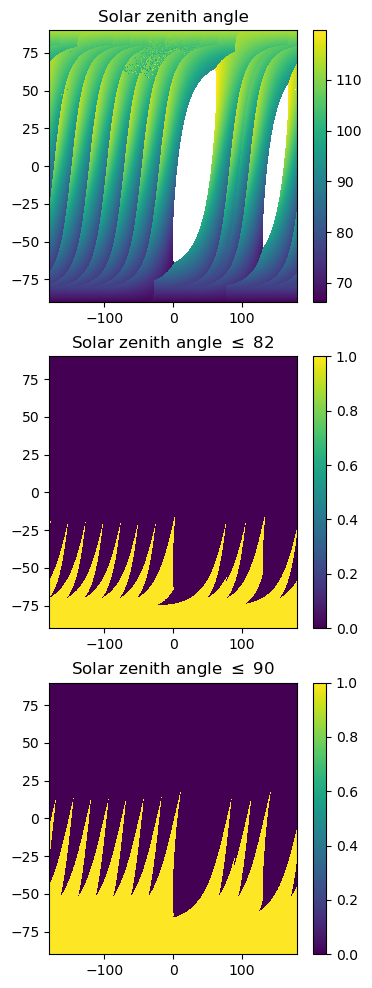

In [17]:
fig, axs = plt.subplots(nrows=3, figsize=(4,3*4))

ax = axs[0]
m = ax.pcolormesh(LON, LAT, ds.solar_zenith_angle.data[0])
fig.colorbar(m, ax=ax)
ax.set_title('Solar zenith angle')

ax = axs[1]
m = ax.pcolormesh(LON, LAT, ds.solar_zenith_angle.data[0] <= 82)
fig.colorbar(m, ax=ax)
ax.set_title('Solar zenith angle $\leq$ 82')

ax = axs[2]
m = ax.pcolormesh(LON, LAT, ds.solar_zenith_angle.data[0] <= 90)
fig.colorbar(m, ax=ax)
ax.set_title('Solar zenith angle $\leq$ 90')

plt.show()

Particularly the solar zenith angle $\leq$ 82 is close to the `twilight_@65-82_solar_zenith` mask, but not exactly:

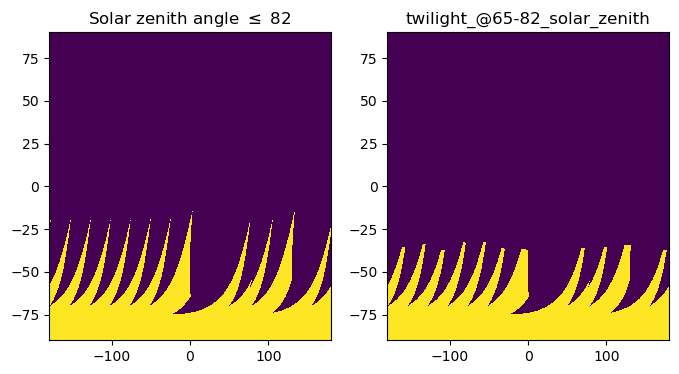

In [18]:
fig, axs = plt.subplots(ncols=2, figsize=(2*4, 4))

ax = axs.ravel()[0]
ax.pcolormesh(LON, LAT, ds.solar_zenith_angle.data[0] <= 82, vmin=0, vmax=1)
ax.set_title('Solar zenith angle $\leq$ 82')

ax = axs.ravel()[1]
ax.pcolormesh(LON, LAT, dcomp_info_unpacked[2], vmin=0, vmax=1)
ax.set_title(ds.dcomp_info.flag_meanings.split()[2])

plt.show()

There is quite a similarity between `valid_cod` and `twilight_@65-82_solar_zenith`:

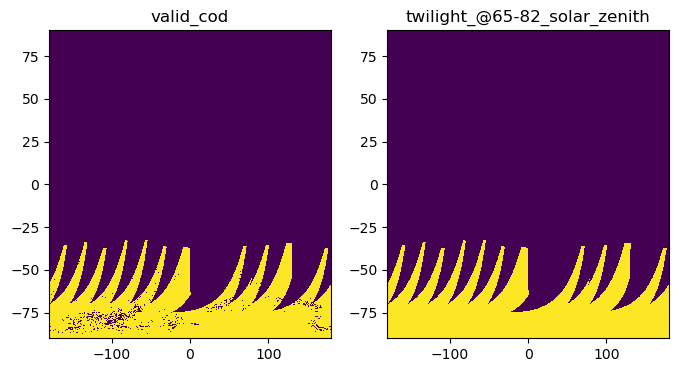

In [19]:
fig, axs = plt.subplots(ncols=2, figsize=(2*4, 4))

ax = axs.ravel()[0]
ax.pcolormesh(LON, LAT, valid_cod, vmin=0, vmax=1)
ax.set_title('valid_cod')

ax = axs.ravel()[1]
ax.pcolormesh(LON, LAT, dcomp_info_unpacked[2], vmin=0, vmax=1)
ax.set_title(ds.dcomp_info.flag_meanings.split()[2])

plt.show()

In [20]:
x = valid_cod
y = dcomp_info_unpacked[2] # 'twilight_@65-82_solar_zenith
# if x is True  and y is True  then c is True
# if x is False and y is True  then c is True
# if x is False and y is False then c is True
# if x is True  and y is False then c is False
c = np.logical_or(np.logical_or(x & y, ~x & y), ~x & ~y)
print(c.all())

False


In [21]:
print((c == False).sum())

1


Essentially, when `valid_cod` is `True`, then so is `twilight_@65-82_solar_zenith`.

I noticed two variables from which it can be extracted whether the cloud phase is `ice`: `cloud_phase == 4` and `liquid_or_ice_phase` bit mask.

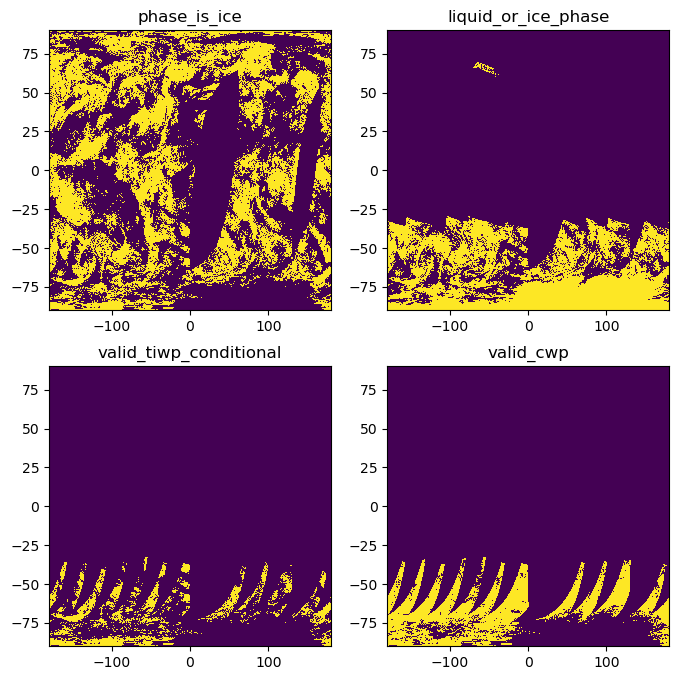

In [22]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(2*4, 2*4))

ax = axs.ravel()[0]
ax.pcolormesh(LON, LAT, phase_is_ice, vmin=0, vmax=1)
ax.set_title('phase_is_ice')

ax = axs.ravel()[1]
ax.pcolormesh(LON, LAT, dcomp_info_unpacked[5], vmin=0, vmax=1)
ax.set_title(ds.dcomp_info.flag_meanings.split()[5])

ax = axs.ravel()[2]
ax.pcolormesh(LON, LAT, valid_tiwp_conditional, vmin=0, vmax=1)
ax.set_title('valid_tiwp_conditional')

ax = axs.ravel()[3]
ax.pcolormesh(LON, LAT, valid_cwp, vmin=0, vmax=1)
ax.set_title('valid_cwp')

plt.show()

`phase_is_ice` and `liquid_or_ice_phase` do not quite agree, but likely is because `liquid_or_ice_phase` requires of another variable to determine whether it should be used.

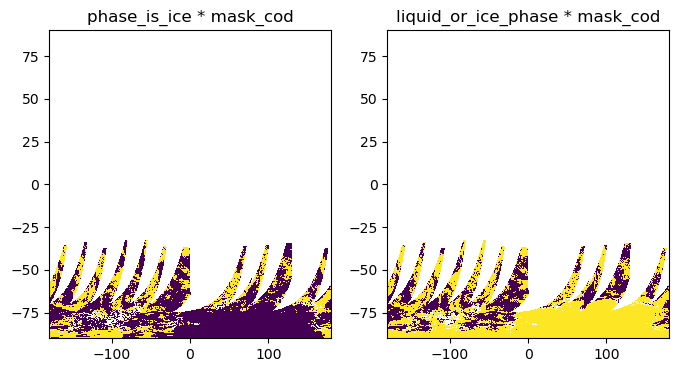

In [23]:
mask_cod = np.where(valid_cod, 1, np.nan)


fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(2*4, 1*4))

ax = axs.ravel()[0]
ax.pcolormesh(LON, LAT, phase_is_ice * mask_cod, vmin=0, vmax=1)
ax.set_title('phase_is_ice * mask_cod')

ax = axs.ravel()[1]
ax.pcolormesh(LON, LAT, dcomp_info_unpacked[5] * mask_cod, vmin=0, vmax=1)
ax.set_title(f'{ds.dcomp_info.flag_meanings.split()[5]} * mask_cod')

plt.show()

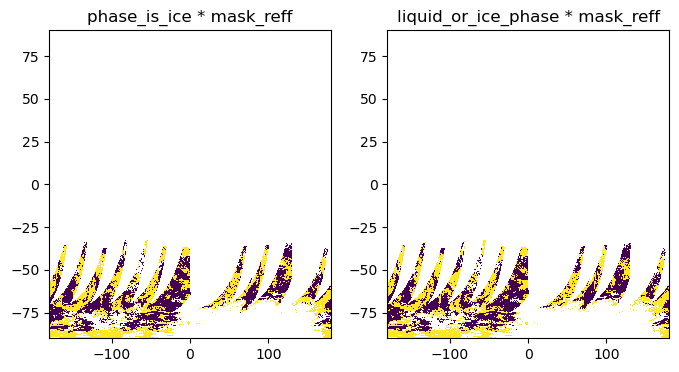

In [24]:
mask_reff = np.where(valid_reff, 1, np.nan)

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(2*4, 1*4))

ax = axs.ravel()[0]
ax.pcolormesh(LON, LAT, phase_is_ice * mask_reff, vmin=0, vmax=1)
ax.set_title('phase_is_ice * mask_reff')

ax = axs.ravel()[1]
ax.pcolormesh(LON, LAT, dcomp_info_unpacked[5] * mask_reff, vmin=0, vmax=1)
ax.set_title(f'{ds.dcomp_info.flag_meanings.split()[5]} * mask_reff')

plt.show()

Remember that:

In [25]:
(valid_reff == valid_cwp).all()

True

The operation below will show `-1` if there are pixels where the cloud phase is ice as indicated by `phase_is_ice` but not by `liquid_or_ice_phase`, `+1`, and `0` when they agree:

In [26]:
np.unique((dcomp_info_unpacked[5].astype(int) - phase_is_ice.astype(int)) * mask_reff)

array([ 0., nan])

So they always agree, except for the `NaN`, which indicates regions where `liquid_or_ice_phase` cannot be used:

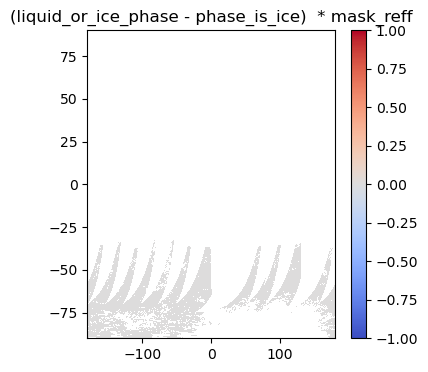

In [27]:
fig, ax = plt.subplots(figsize=(4,4))

m = ax.pcolormesh(LON, LAT, (dcomp_info_unpacked[5].astype(int) - phase_is_ice.astype(int)) * mask_reff, vmin=-1, vmax=1, cmap='coolwarm')
fig.colorbar(m, ax=ax)
ax.set_title('(liquid_or_ice_phase - phase_is_ice)  * mask_reff')

plt.show()

Therefore,
- `valid_cod` captures the region where DCOMP is executed
- `valid_cwp` is NaN when:
  - the daytime conditions are not met for DCOMP
  - There is no cloud
  - DCOMP failed
- `cloud_phase == 4` is a generalization of `liquid_or_ice_phase` (the latter is `False` if liquid, `True` if ice)

In conclusion, to extract the IWP:

In [28]:
iwp = xr.where(
    np.isfinite(ds.cld_opd_dcomp),
    1,
    np.nan
) * xr.where(
    ds['cloud_phase'] == 4,
    ds.cld_cwp_dcomp,
    0
)

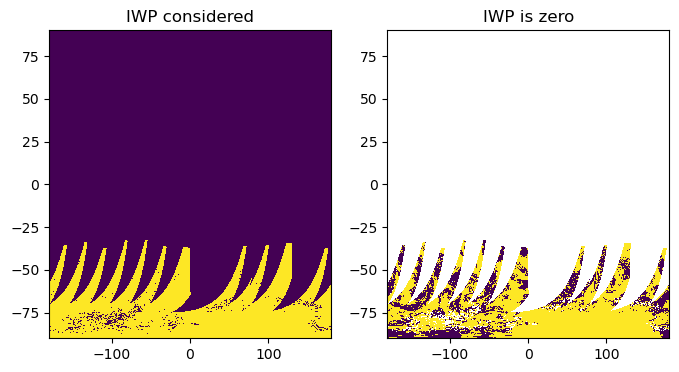

In [29]:
fig, axs = plt.subplots(ncols=2, figsize=(2 * 4,4))

ax = axs[0]
ax.pcolormesh(LON, LAT, np.isfinite(iwp.data[0]))
ax.set_title('IWP considered')

ax = axs[1]
ax.pcolormesh(LON, LAT, np.where(iwp.data[0] == 0, True, np.where(np.isfinite(iwp.data[0]), 0, np.nan)))
ax.set_title('IWP is zero')

plt.show()